<a href="https://colab.research.google.com/github/hflautert/AnomalyDetection/blob/main/AnomaliaICMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experimento de reconhecimento de anomalias em ataque DoS do tipo ICMP.

Fonte de dados:

Rede normal:
https://iotanalytics.unsw.edu.au/anomaly-data/pcap/benign/18-05-31.pcap

Rede com ataques:
https://iotanalytics.unsw.edu.au/anomaly-data/pcap/AttackAndBenign/18-06-02.pcap

Descrição dos ataques:
https://iotanalytics.unsw.edu.au/anomaly-data/attackinfo.xlsx

Para gerar as estatísticas, os arquivos foram abertos com WireShark, aplicado filtro `icmp`. Posteriormente gerado dados no menu Statistics, I/O Graph, salvo como csv, nos intervalos de 1 minuto, 10 segundos, e 1 segundo.

Ataques ICMP contabilizados com WireShark = [22](https://github.com/hflautert/AnomalyDetection/blob/main/Prints/WS_ICMP_n.PNG).

Exceto o tempo de 100ms - devido ao estouro na exportação do WireShark, foi realizado recorte de somente 6 ataques.

In [32]:
# Importando bibliotecas
# Manipulação de matrizes e operações matemáticas de alto nível
import numpy as np
# Geração de gráficos
import matplotlib.pyplot as plt
# Funcoes media movel
import httpimport
url = "https://gist.githubusercontent.com/hflautert/5bf858b4dc005877dcd340e67d9c4e85/raw/583b3967b639335ddd701dd73a9f97477dc38eec"
with httpimport.remote_repo(url):
  import funcoesmm as fmm

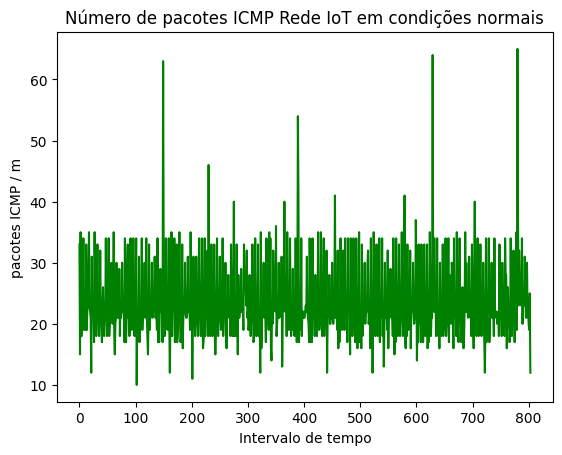

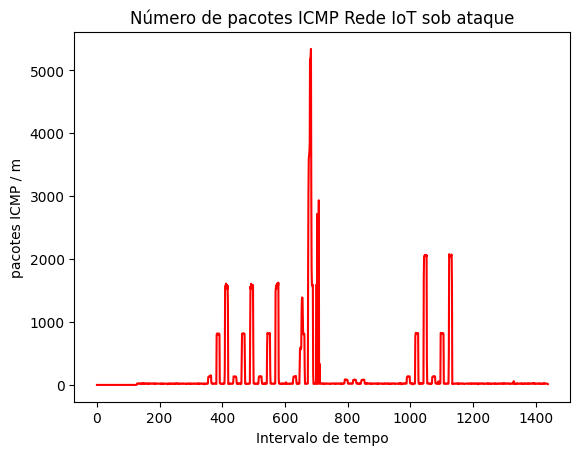

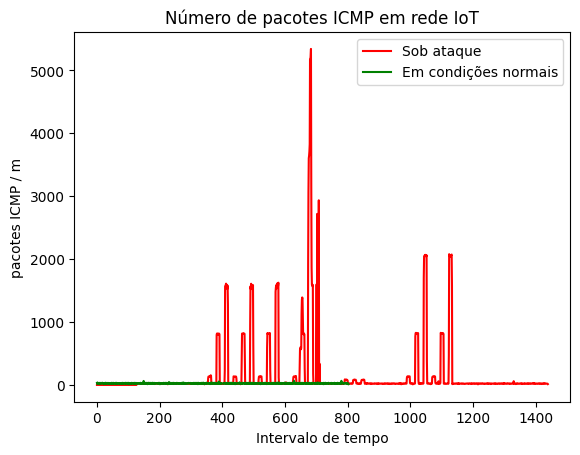

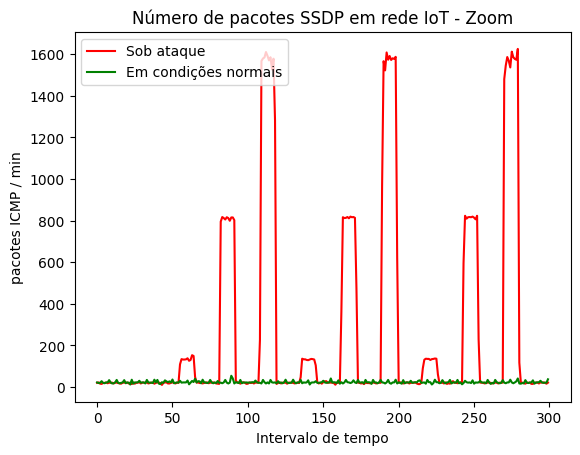

In [33]:
# Carregando dados

dados_normal_1m = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_icmp_1m.csv")
dados_normal_10s = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_icmp_10s.csv")
dados_normal_1s = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_icmp_1s.csv")
dados_normal_500ms = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_icmp_500ms.csv")
dados_normal_100ms = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-05-31_benign_icmp_100ms.csv")

dados_ataque_1m = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_icmp_1m.csv")
dados_ataque_10s = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_icmp_10s.csv")
dados_ataque_1s = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_icmp_1s.csv")
dados_ataque_500ms = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_icmp_500ms.csv")
dados_ataque_100ms = fmm.prep_csv("https://raw.githubusercontent.com/hflautert/AnomalyDetection/main/Stats/18-06-02_icmp_100ms_6.csv")

tipo_dos_pacotes='ICMP'

fmm.visualiza(dados_normal_1m,'m','g','Rede IoT em condições normais',tipo_dos_pacotes)
fmm.visualiza(dados_ataque_1m,'m','r','Rede IoT sob ataque',tipo_dos_pacotes)
fmm.visualizamix(dados_ataque_1m,'r',dados_normal_1m,'g','m',tipo_dos_pacotes)

# Vizualização otimizada com zoom na janela de ataque de 1, 10 e 100 pcts/s
v_dados_normal_1m = dados_normal_1m[300:600]
v_dados_ataque_1m = dados_ataque_1m[300:600]

# Unindo linhas
plt.plot(v_dados_ataque_1m, color = 'r', label = "Sob ataque")
plt.plot(v_dados_normal_1m, color = 'g', label = "Em condições normais")
plt.title('Número de pacotes SSDP em rede IoT - Zoom')
plt.xlabel('Intervalo de tempo')
plt.ylabel('pacotes '+tipo_dos_pacotes+' / min')
plt.legend()
plt.show()

Total de ataques identificados: 22


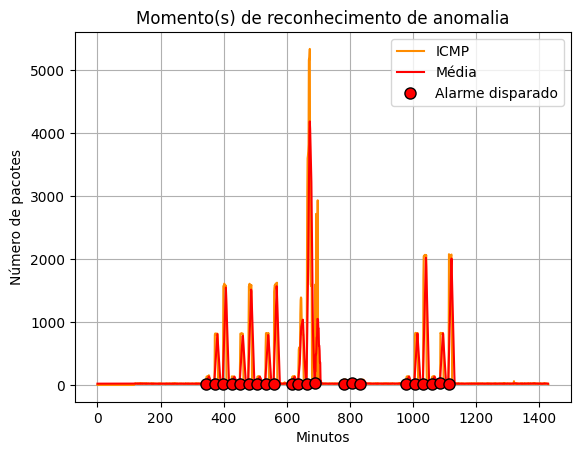

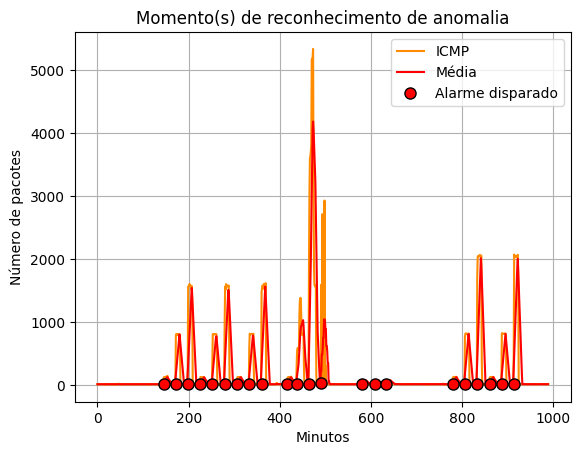

Falsos positivos: 0


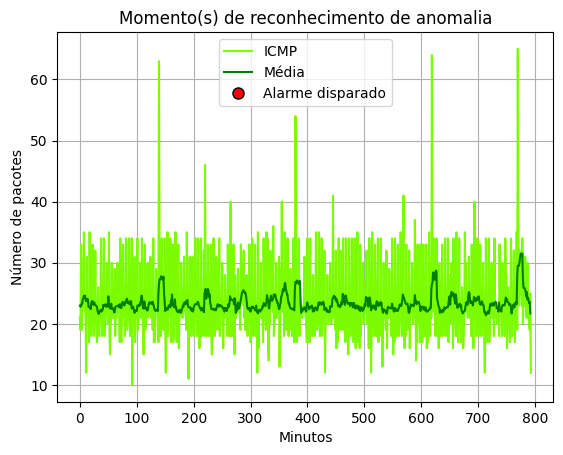

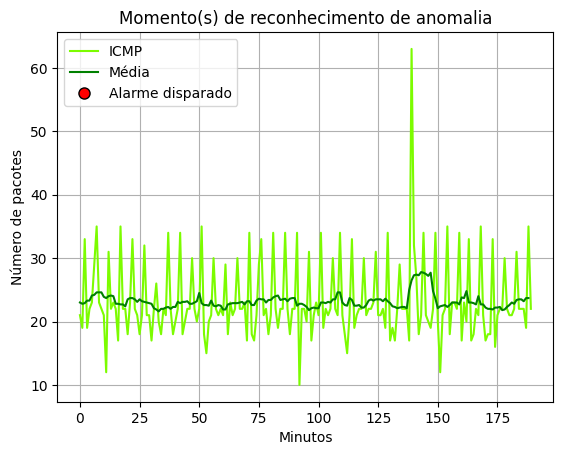

In [34]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_1m
dados_ataque=dados_ataque_1m
unidade_de_tempo='Minutos'
delta=1.1
intervalo=10
taxa_minima=20

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)
# Recorte para aproximacao
dados_ataque=dados_ataque[200:1200]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)
# Recorte para aproximacao
dados_normal=dados_normal[:200]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)

Total de ataques identificados: 22


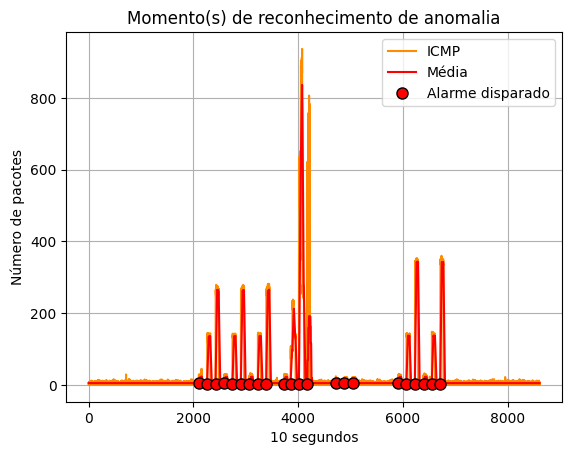

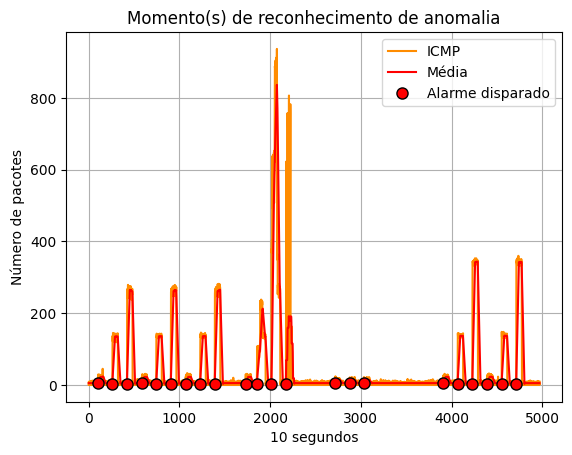

Falsos positivos: 1


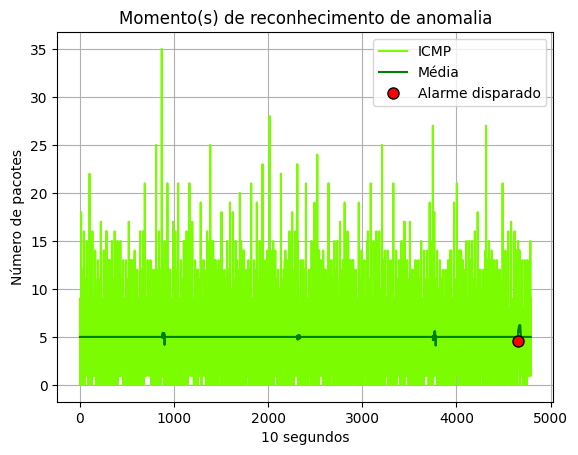

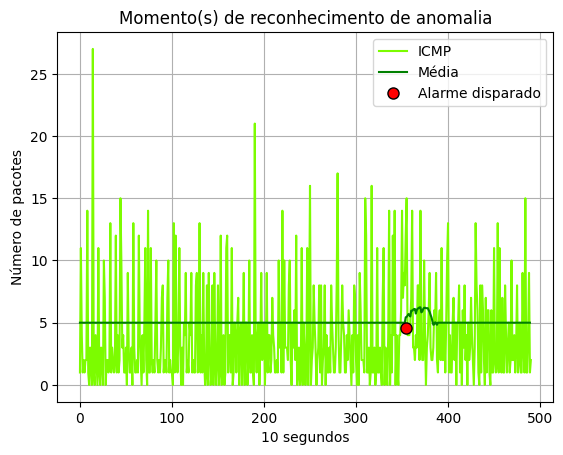

In [35]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_10s
dados_ataque=dados_ataque_10s
unidade_de_tempo='10 segundos'
delta=1.065
intervalo=30
taxa_minima=5

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)
# Recorte para aproximacao
dados_ataque=dados_ataque[2000:7000]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)
# Recorte para aproximacao
dados_normal=dados_normal[4300:]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)

Total de ataques identificados: 18


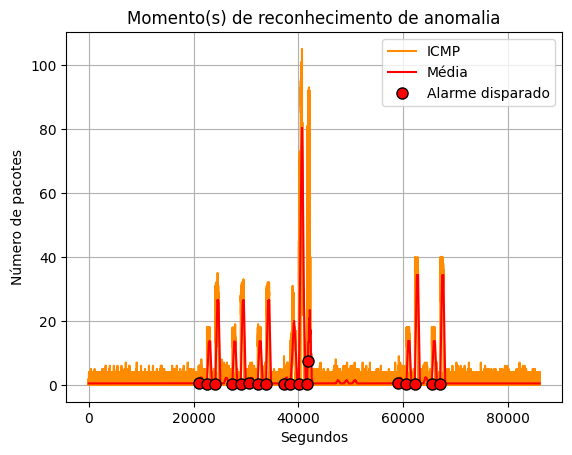

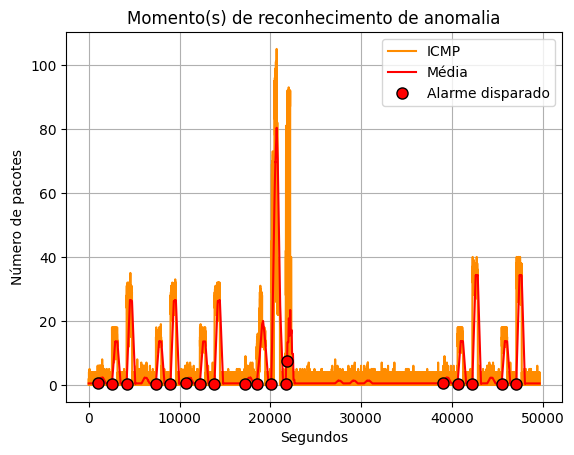

Falsos positivos: 1


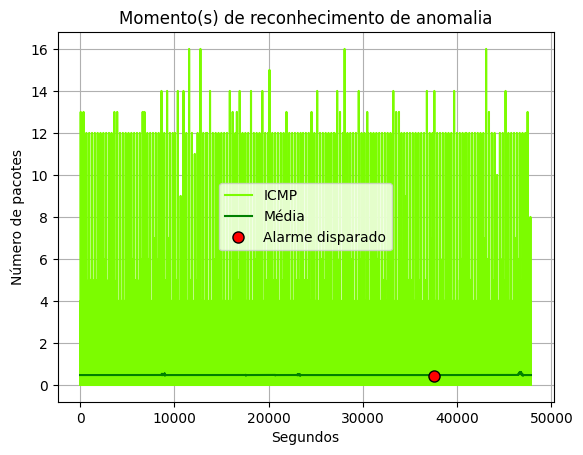

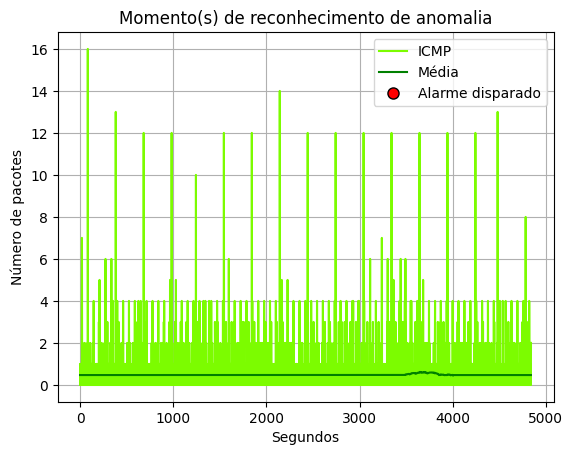

In [36]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_1s
dados_ataque=dados_ataque_1s
unidade_de_tempo='Segundos'
delta=1.02
intervalo=360
taxa_minima=0.47

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)
# Recorte para aproximacao
dados_ataque=dados_ataque[20000:70000]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)
# Recorte para aproximacao
dados_normal=dados_normal[43000:]
ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)

Total de ataques identificados: 18


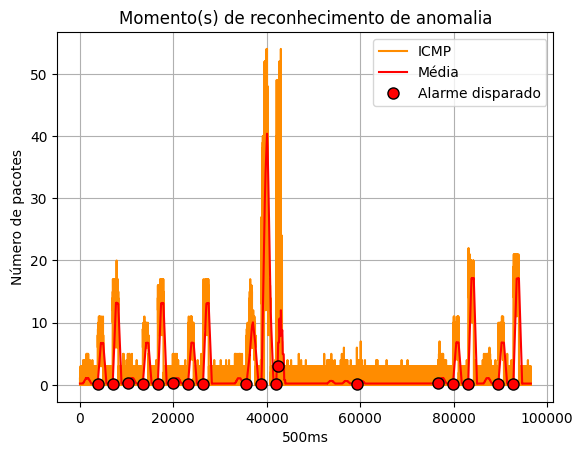

Falsos positivos: 0


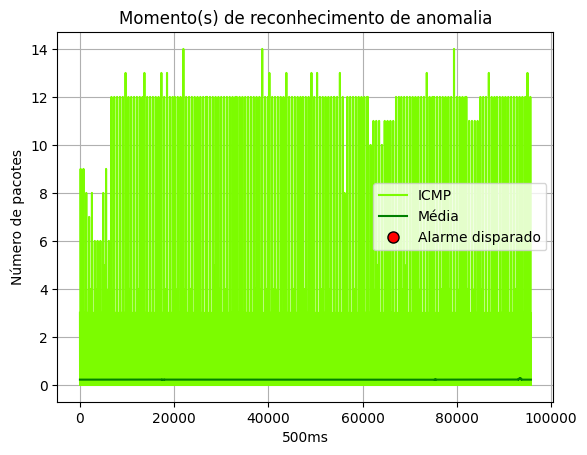

In [37]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_500ms
dados_ataque=dados_ataque_500ms
unidade_de_tempo='500ms'
delta=1.01
intervalo=700
taxa_minima=0.22

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)


Total de ataques identificados: 6


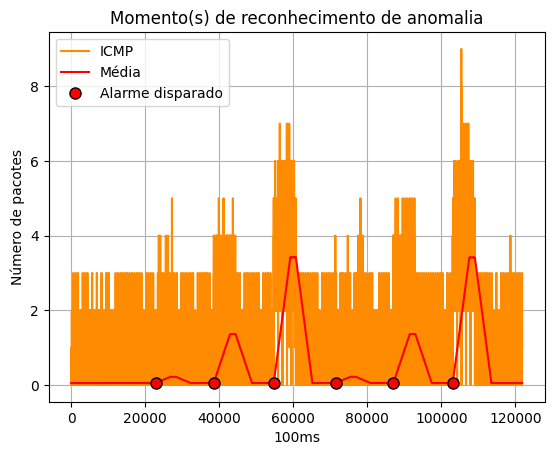

Falsos positivos: 0


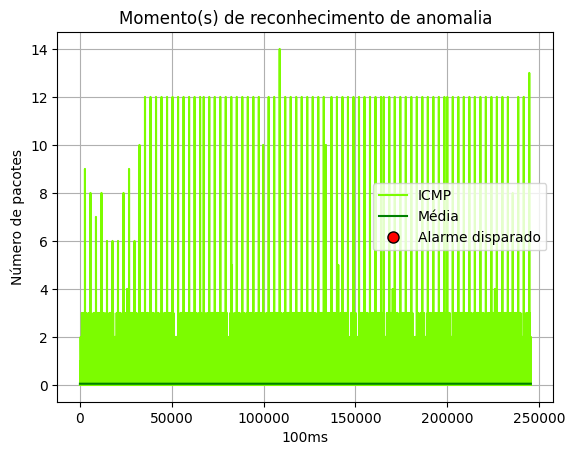

In [41]:
## Para reaproveitamento das chamadas
dados_normal=dados_normal_100ms
dados_ataque=dados_ataque_100ms
unidade_de_tempo='100ms'
delta=1.008
intervalo=4500
taxa_minima=0.05

ataques_reconhecidos,falsos_positivos,alarme_normal_pos,alarme_normal_val,alarme_ataque_pos,alarme_ataque_val,media_normal,media_ataque=fmm.aplica_modelo(dados_normal,dados_ataque,delta,intervalo,taxa_minima)

print ("Total de ataques identificados:",ataques_reconhecidos)
fmm.visualiza_alarmes(dados_ataque,alarme_ataque_pos,alarme_ataque_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'darkorange','r',media_ataque)

print ("Falsos positivos:",falsos_positivos)
fmm.visualiza_alarmes(dados_normal,alarme_normal_pos,alarme_normal_val,unidade_de_tempo,tipo_dos_pacotes,intervalo,'lawngreen','g',media_normal)